In [18]:
import re
import numpy as np
import time
from pathlib import Path
from typing import Optional, Union
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
from datetime import datetime

import png
import os
import yaml
import imageio

import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter

import subprocess
import platform
import threading
from matplotlib.colors import LinearSegmentedColormap

from image_analysis.utils import read_imaq_png_image

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info('Undulator')

In [169]:
#Some functions below to establish paths to data, analysis directory. Automatically detects if the computre is on the domain, if it is
#use the given path. Other wise, check hostname and decide path based off of that

def get_domain_windows():
    try:
        # Simplifying command execution, focusing on parsing the domain directly
        result = subprocess.check_output(['systeminfo'], stderr=subprocess.STDOUT, text=True)
        domain_line = next((line for line in result.splitlines() if "Domain" in line), None)
        if domain_line:
            return domain_line.split(':')[1].strip()
    except Exception as e:
        # Logging or handling the exception can be done here if necessary
        return None

def get_base_path():
    # Attempt to retrieve the domain, falling back to hostname if needed
    domain = get_domain_windows()
    hostname = platform.node()

    # Directly mapping conditions to base paths, raising an error if none match
    if domain == 'loasis.gov':
        return 'Z:\\data\\Undulator'
    elif hostname == 'Samuels-MacBook-Pro.local':
        return '/Volumes/vol1/data/Undulator'
    else:
        raise ValueError('Attempting to use an unknown computer. Path to data is unknown.')


def get_current_date():
    month_dict2= {
        "01": "Jan", "02": "Feb", "03": "Mar", "04": "04-Apr",
        "05": "May", "06": "Jun", "07": "07-Jul", "08": "08-Aug",
        "09": "Sep", "10": "Oct", "11": "11-Nov", "12": "12-Dec"
    }

    # Get the current date and time
    current_date_time = datetime.now()

    month = month_dict2[current_date_time.strftime("%m")]
    year = current_date_time.strftime("%Y")
    day = current_date_time.strftime("%d")

    return year, month, day

def create_data_path(year, month, day, scan_number):
    # Mapping of month names to their abbreviated forms with month numbers
    month_dict = {
        "Jan": "01-Jan", "Feb": "02-Feb", "Mar": "03-Mar", "Apr": "04-Apr",
        "May": "05-May", "Jun": "06-Jun", "Jul": "07-Jul", "Aug": "08-Aug",
        "Sep": "09-Sep", "Oct": "10-Oct", "Nov": "11-Nov", "Dec": "12-Dec"
    }

    # Extracting year's last two digits and month number from month_dict
    year_short = str(year)[-2:]
    month_num = month_dict[month][:2]

    # Constructing paths for raw and analysis data
    date_folder = f"{year_short}_{month_num}{str(day).zfill(2)}"  # Ensures day is zero-padded
    base_folder = Path(base_path) / f"Y{year}" / month_dict[month] / date_folder
    raw_data_path = base_folder / "scans" / f"Scan{scan_number:03d}"
    analysis_data_path = base_folder / "analysis" / f"Scan{scan_number:03d}"

    return str(raw_data_path), str(analysis_data_path)

def count_files_in_scan_directory(scan_dir_base, device):
    device_dir = Path(scan_dir_base) / device
    # Count files in the device directory
    if device_dir.exists():
        count = len(list(device_dir.glob('*png')))  # Assuming you want to count all types of files
        file_counts = count
    return file_counts

def create_average_image_file_name(device, station = None):
    filename = f'{device}{"" if station is None else "_"+station}{"_average"}_16bit.png'
    return filename

# Function to load or initialize the YAML data structure
def load_create_scan_aux_data(file_path):
    if file_path.exists():
        with file_path.open('r') as file:
            return yaml.safe_load(file) or {"image_count": {}, "raw_data_path": {}, "analyzed_data_path": {}}
    else:
        return {"image_count": {}, "raw_data_path": {}, "analyzed_data_path": {}}

# Function to update the YAML data with new device info
def update_scan_aux_data(file_path, device, num_images, scan_dir, analysis_dir):
    data = load_create_scan_aux_data(file_path)
    
    # Add or update the device data
    data["image_count"][device] = num_images
    data["raw_data_path"][device] = str(scan_dir)  # Ensure paths are strings
    data["analyzed_data_path"][device] = str(analysis_dir)
    
    # Write the updated data back to the YAML file
    with file_path.open('w') as file:
        yaml.safe_dump(data, file, sort_keys=False)



def create_avg_image(scan_dir_base, analysis_dir_base, device, station=None, show_image=False):
    # Set up directories and file paths
    image_dir = Path(scan_dir_base) / device
    analysis_dir = Path(analysis_dir_base)
    yaml_file_path = analysis_dir / 'aux_data.yaml'
    
    # Load images
    all_imgs = [read_imaq_png_image(path) for path in image_dir.glob('*.png')]
    if not all_imgs:
        print(f"No images found in directory: {image_dir}")
        return

    # Process and display average image
    avg_img = np.mean(all_imgs, axis=0).astype(np.uint16)
    if show_image:
        plt.imshow(avg_img, cmap='gray', vmin=0, vmax=np.max(avg_img))
        plt.colorbar(label="Scale")
        plt.title("2D Array Visualization")
        plt.show()

    # Save average image
    analysis_dir.mkdir(parents=True, exist_ok=True)
    filename = create_average_image_file_name(device, station)  # Assumes existence of this function
    imageio.imwrite(analysis_dir / filename, avg_img)
    print(f"Saved image to: {analysis_dir / filename}")

    # Update YAML file with image count
    update_scan_aux_data(yaml_file_path, device, num_images, scan_dir_base, analysis_dir_base)
    print(f"Updated YAML file with image count for device: {device}")



# Helper function for CMYK to RGB conversion
def cmyk_to_rgb(c, m, y, k):
    """Convert CMYK values to RGB."""
    r = 255 * (1.0 - c) * (1.0 - k)
    g = 255 * (1.0 - m) * (1.0 - k)
    b = 255 * (1.0 - y) * (1.0 - k)
    return r / 255.0, g / 255.0, b / 255.0

def create_cross_mask(image, cross_center, angle, cross_height=54, cross_width=54, thickness=8 ):
    """
    Creates a mask with a cross centered at `cross_center` with the cross being zeros and the rest ones.
    
    Args:
    - image (np.array): The image on which to base the mask size.
    - cross_center (tuple): The (x, y) center coordinates of the cross.
    - cross_height (int): The height of the cross extending vertically from the center.
    - cross_width (int): The width of the cross extending horizontally from the center.
    - thickness (int): The thickness of the lines of the cross.
    
    Returns:
    - np.array: The mask with the cross.
    """
    
    # Create a mask filled with ones (white)
    mask = np.ones_like(image, dtype=np.uint8)
    
    # Unpack the center coordinates
    x_center, y_center = cross_center
    
    # Define the vertical and horizontal ranges for the cross
    vertical_start = max(y_center - cross_height, 0)
    vertical_end = min(y_center + cross_height, image.shape[0])
    horizontal_start = max(x_center - cross_width, 0)
    horizontal_end = min(x_center + cross_width, image.shape[1])
    
    # Set the cross area to zero (black)
    mask[vertical_start:vertical_end, x_center - thickness // 2:x_center + thickness // 2] = 0
    mask[y_center - thickness // 2:y_center + thickness // 2, horizontal_start:horizontal_end] = 0

    # Get the rotation matrix for rotating the mask
    M = cv2.getRotationMatrix2D(cross_center, angle, 1.0)
    
    # Rotate the mask using the rotation matrix, using the nearest neighbor interpolation
    rotated_mask = cv2.warpAffine(mask, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=1)
    
    return rotated_mask


def get_analysis_settings(device, station=None):
    """
    Determine and load the analysis settings based on the device and optional station.

    Args:
        device (str): The name of the device, which may include a numerical suffix.
        station (str, optional): The name of the station, relevant for some devices.

    Returns:
        dict: The loaded analysis settings from the YAML configuration.
    """
    # Define a strategy to select the configuration file based on device name patterns
    if "UC_UndulatorRad2" in device:
        config_path = "Rad2_analysis_settings.yml"
    elif "UC_VisaEBeam" in device:
        # Assuming all UC_VisaEBeamX devices share the same config structure
        config_path = "visa_analysis_settings.yml"
    else:
        # Fallback to a default config if the device pattern is not recognized
        config_path = "default_config.yml"
    
    # Attempt to load the configuration file
    try:
        with open(config_path, 'r') as file:
            cam_settings = yaml.safe_load(file)
    except FileNotFoundError:
        print(f"Error: The configuration file '{config_path}' was not found.")
        return {}
    
    # Extract the analysis settings for the specific device or station
    if "UC_UndulatorRad2" in device and station:
        # For UC_UndulatorRad2, settings may be under the station name
        analysis_settings = cam_settings.get(station, {})
    else:
        # For other devices, settings are expected under the device name
        analysis_settings = cam_settings.get(device, {})

    return analysis_settings

def load_and_preprocess_image(image_path, analysis_settings):
    """
    Load an image and apply initial preprocessing steps.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Preprocessed image.
    """
    image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)

    cropped_image = image[analysis_settings['Top ROI']:analysis_settings['Top ROI'] + analysis_settings['Size_Y'],
                          analysis_settings['Left ROI']:analysis_settings['Left ROI'] + analysis_settings['Size_X']]

    return cropped_image


def apply_masks_and_filters(image, analysis_settings):
    """
    Apply cropping, masks, background subtraction, and filters to the image.

    Args:
        image (numpy.ndarray): The image to process.
        analysis_settings (dict): Settings for processing, including cropping coordinates, mask settings, and filter settings.

    Returns:
        numpy.ndarray: The processed image.
    """
    processed_image = image

    # Apply masks (assuming `create_cross_mask` is a function you have defined)
    if 'Cross1' in analysis_settings:
        cross_location = analysis_settings['Cross1']
        cross_location[0] = cross_location[0] + + analysis_settings['Cross Shift']
        mask1 = create_cross_mask(processed_image, cross_location, analysis_settings['Rotate'])
        processed_image *= mask1

    if 'Cross2' in analysis_settings:
        cross_location = analysis_settings['Cross2']
        cross_location[0] = cross_location[0] + analysis_settings['Cross Shift']
        mask2 = create_cross_mask(processed_image, cross_location, analysis_settings['Rotate'])
        processed_image *= mask2

    # # Subtract background level and apply filters
    # cropped_image = np.maximum(cropped_image - analysis_settings['Background Level'], 0)

    processed_image = processed_image.astype('float32')
    processed_image = processed_image - analysis_settings['Background Level']*.4
    processed_image[processed_image < 0] = 0
    
    for _ in range(analysis_settings.get('Median Filter Cycles', 0)):
        processed_image = median_filter(processed_image, size=analysis_settings['Median Filter Size'])

    for _ in range(analysis_settings.get('Gaussian Filter Cycles', 0)):
        processed_image = gaussian_filter(processed_image, sigma=analysis_settings['Gaussian Filter Size'])

    return processed_image


def save_processed_image(image, image_path,):
    """
    Save the processed image to disk.

    Args:
        image (numpy.ndarray): The image to save.
        image_path (str): Original image path to derive the save location and filename.
    """
    raw_image_filename = os.path.splitext(os.path.basename(image_path))[0] + "_raw_processed.png"
    raw_image_save_path = os.path.join(os.path.dirname(image_path), raw_image_filename)
    cv2.imwrite(raw_image_save_path, image.astype('uint16'))
    # print(f"Processed image saved to {raw_image_save_path}")

def display_and_save_customized_image(image, image_path, show_image=True, plot_label = None, normalize=True, scaling=8):
    """
    Display the image using matplotlib and save the displayed image to disk.

    Args:
        image (numpy.ndarray): The image to display and save.
        image_path (str): Original image path to derive the save location and filename.
        show_image (bool): Whether to show the image in a matplotlib window.
    """

    # Check if the maximum value in the image is greater than 0
    if normalize:
        if np.max(image) > 0:
            display_image = image / np.max(image) * (2**8 - 1)
        else:
            # This creates a uniformly black image in the context of grayscale uint8 images
            display_image = np.zeros_like(image)
    else:
        display_image = image /  (2**16 - 1) * (2**scaling-1)

    display_image = display_image.astype('uint8')

    fig, ax = plt.subplots(figsize=(4 , 4 ))

    # Plot the image data on the respective subplot
    ax.imshow(display_image, cmap=custom_cmap)
    if plot_label is not None:
        ax.set_title(plot_label)
            
    # Restore the axis grid and ticks
    ax.grid(True)  # Turn on the grid
    ax.set_xticks([])  # Set the x-ticks to an empty list if you don't want any ticks
    ax.set_yticks([])  # Set the y-ticks to an empty list if you don't want any ticks
    if "UC_Visa" in str(image_path):
        # If you want to show the grid ticks, you can specify them explicitly, e.g.:
        ax.set_xticks([0, 50, 100, 150,200,250,300])
        ax.set_yticks([0, 50, 100, 150,200,250,300])

    if "UC_UndulatorRad2" in str(image_path):
        # If you want to show the grid ticks, you can specify them explicitly, e.g.:
        ax.set_xticks([0,100,200,300,400,500])
        ax.set_yticks([0,100,200,300,400])

    # Save the customized image
    fig.tight_layout()
    save_path = os.path.splitext(image_path)[0] + "_customized.png"
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.01)
    if show_image:
        None
    else:
        plt.close(fig)  # Close the figure to free memory

    return save_path

def plot_image_with_customizations(image_path, analysis_settings, show_image=True, plot_label = None, normalize=True,scaling=8):
    """
    Main function to load, process, display, and save an image with customizations.

    Args:
        image_path (str): Path to the image file.
        analysis_settings (dict): Settings for image processing and customization.
        show_image (bool): Whether to display the processed image.
    """
    image = load_and_preprocess_image(image_path, analysis_settings)
    processed_image = apply_masks_and_filters(image, analysis_settings)
    save_processed_image(processed_image, image_path)
    
    # if show_image:
    save_path = display_and_save_customized_image(processed_image, image_path, show_image=show_image, plot_label = plot_label, normalize=normalize, scaling=scaling)

    return processed_image, save_path

def image_analysis(image):
    """
    Analyze the image to calculate the center of mass, second moment, FWHM, 
    and position of max value of both horizontal and vertical projections.

    Args:
    - image (np.array): A grayscale image array.

    Returns:
    - dict: Analysis results containing centers of mass, second moments,
            FWHMs, and positions of max values for both directions.
    """

    # Check if the image is all zeros or the sum of the projections are zero
    if np.all(image == 0) or np.sum(image) == 0:
        # Return a dictionary with all values set to 0 if image is all zeros or sum of projections is zero
        return {
            'Center of Mass': [0, 0],
            'Second Moment': [0, 0],
            'FWHM': [0, 0],
            'Max Value Position': [0, 0],
            'Sum Counts': 0,
            'Max Count': 0
        }
    
    # Calculate the projections by summing the image array along the axes
    horizontal_projection = np.sum(image, axis=0)  # Sum over rows for each column
    vertical_projection = np.sum(image, axis=1)  # Sum over columns for each row
    
    # Calculate the center of mass (first moment) for the projections
    def center_of_mass(projection):
        positions = np.arange(len(projection))
        return np.sum(positions * projection) / np.sum(projection)
    
    # Calculate the second moment (variance) for the projections
    def second_moment(projection, com):
        positions = np.arange(len(projection))
        return np.sqrt(np.sum((positions - com)**2 * projection) / np.sum(projection))
    
    # Calculate the Full Width at Half Maximum (FWHM) for the projections
    def fwhm(projection):
        half_max = np.max(projection) / 2
        indices_above_half_max = np.where(projection >= half_max)[0]
        return np.abs(indices_above_half_max[-1] - indices_above_half_max[0])

    # Calculate the position of the max value for the projections
    def max_value_position(projection):
        return np.argmax(projection)

    # Perform calculations
    com_horizontal = center_of_mass(horizontal_projection)
    com_vertical = center_of_mass(vertical_projection)
    moment2_horizontal = second_moment(horizontal_projection, com_horizontal)
    moment2_vertical = second_moment(vertical_projection, com_vertical)
    fwhm_horizontal = fwhm(horizontal_projection)
    fwhm_vertical = fwhm(vertical_projection)
    max_pos_horizontal = max_value_position(horizontal_projection)
    max_pos_vertical = max_value_position(vertical_projection)
    sum_counts = np.sum(horizontal_projection)
    
    # Compile results
    results = {
        'Center of Mass': [com_horizontal, com_vertical],
        'Second Moment': [moment2_horizontal, moment2_vertical],
        'FWHM': [fwhm_horizontal, fwhm_vertical],
        'Max Value Position': [max_pos_horizontal, max_pos_vertical],
        # 'Projections': [horizontal_projection, vertical_projection],
        'Sum Counts': sum_counts,
        'Max Count': np.max(image)
    }

    return results

def full_process(year, month, day, scan_number, device, station, show_image=False, plot_label=None, normalize = True, scaling=8):
    
    scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
    
    analysis_settings = get_analysis_settings(device, station)
    filename = create_average_image_file_name(device,station)
    image_path = Path(analysis_dir_base) / filename
    print(image_path)
    yaml_file_path = Path(analysis_dir_base) / 'aux_data.yaml'
    
    test, save_path = plot_image_with_customizations(image_path , analysis_settings, show_image=show_image, plot_label=plot_label, normalize = normalize, scaling=scaling)

    res = image_analysis(test)
   
    # Update YAML file with image count
    if yaml_file_path.exists():
        aux_data = yaml.safe_load(yaml_file_path.read_text())
        res['image_count'] = aux_data["image_count"][device]    

    return save_path, res

def create_next_special_scan_directory(working_dir, special_scan_base_name):
    # Find existing directories with the base name
    existing_dirs = [dir for dir in working_dir.iterdir() if dir.is_dir() and special_scan_base_name in dir.name]
    
    # Extract suffix numbers and find the next available number
    suffixes = [int(dir.name.replace(special_scan_base_name, '')) for dir in existing_dirs if dir.name.replace(special_scan_base_name, '').isdigit()]
    next_number = max(suffixes) + 1 if suffixes else 1
    
    # Create new directory with the next number
    new_dir_name = f"{special_scan_base_name}{next_number}"
    new_dir_path = working_dir / new_dir_name
    new_dir_path.mkdir(exist_ok=True)  # Create the directory, ignore if it already exists
    
    return new_dir_path

def undulator_screen_scan():
    #undulator position scan with post analysis

    use_threading = True
    threads = []
    year, month, day = get_current_date()
    dummy_scan_number = 100
    scan_dir_base, analysis_dir_base = create_data_path(year, month, day, dummy_scan_number)
    special_scan_base_name = 'undulator_screen_scan'
    working_dir = Path(analysis_dir_base).parent 
    undulator_scan_dir = create_next_special_scan_directory(working_dir, special_scan_base_name)

    ebeam_scan_numbers = []
    rad2_scan_numbers = []
    for i in range(len(plunger_var_alias)):  # +1 to include the last scan for visa 9
        retract_all_plungers()
        time.sleep(1)
        if plunger_var_alias[i] != 'visa9':
            visa_plungers.set(plunger_var_names[i], 'on')  
        elif plunger_var_alias[i] == 'visa9':
            plc.set("DO.Ch19", 'on')
        time.sleep(1)
        print(f'set plunger: visa{i+1}')
        position = rad2_positions[i]
        velmex.set("Position", position)
        print(f'moved velmex to: {position}')
        time.sleep(1)
        
        scan_success = False
        ebeam_scan_success = False
        rad2_scan_success = False
        requested_shots = 15
        while not scan_success:
            velmex.no_scan(comment=f"no scan on visa plunger: {plunger_var_alias[i]}", shots=requested_shots)
            scan_number = velmex.last_scan_number()
            scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
            
            urad_numfiles = count_files_in_scan_directory(scan_dir_base,'UC_UndulatorRad2')
            if urad_numfiles >= 0.74 * requested_shots:
                rad2_scan_success = True
                
            if plunger_var_alias[i] != 'visa9':
                ebeam_numfiles = count_files_in_scan_directory(scan_dir_base, f'UC_VisaEBeam{i+1}')
                if ebeam_numfiles >= 0.74 * requested_shots:
                    ebeam_scan_success = True
            else:
                ebeam_scan_success = True

            if ebeam_scan_success and rad2_scan_success:
                print("successful scan")
                break
        
        if plunger_var_alias[i] != 'visa9':
            ebeam_scan_numbers.append(scan_number)
        rad2_scan_numbers.append(scan_number)
        
        if use_threading:
            if plunger_var_alias[i] != 'visa9':
                t1 = threading.Thread(target=create_avg_image, args=(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{i+1}', None),kwargs={'show_image': False})
                t1.start()
                threads.append(t1) 
            
            t2 = threading.Thread(target=create_avg_image, args=(scan_dir_base, analysis_dir_base, 'UC_UndulatorRad2', f'Station{i+1}'),kwargs={'show_image': False})
            t2.start()
            threads.append(t2)            
            
        else:
            if plunger_var_alias[i] != 'visa9':
                create_avg_image(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{i+1}', show_image = False)
            create_avg_image(scan_dir_base, analysis_dir_base, f'UC_UndulatorRad2',station = f'Station{i+1}', show_image = False)

    if use_threading:
        # Wait for all threads to finish
        for thread in threads:
            thread.join()

    estats = create_image_grids("UC_VisaEBeam", ebeam_scan_numbers, undulator_scan_dir,  year, month, day,figsize=(15, 7),grid_rows=2,grid_cols=4)
    radstats = create_image_grids("UC_UndulatorRad2", rad2_scan_numbers, undulator_scan_dir, year, month, day,figsize=(15, 15),grid_rows=3,grid_cols=3)
    
    return ebeam_scan_numbers, rad2_scan_numbers, undulator_scan_dir, year, month, day

def convert_types(obj):
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(value) for value in obj]
    else:
        return obj

def create_image_grids(device,scan_numbers,undulator_scan_dir,year,month,day,figsize=(15,15),grid_rows=3,grid_cols=3,static_device=False, normalize=True,scaling=8):

    fig_paths = []
    all_stats = {}
    
    # Determine the base file name based on the device type
    if device == "UC_UndulatorRad2":
        file_save_name = 'urad2_image_grid.png'
        stats_save_name = 'urad2_stats.yml'
        # grid_rows = 3
        # grid_cols = 3
        # figsize = (15, 15)
    elif "UC_VisaEBeam" in device:
        file_save_name = 'visa_image_grid.png'
        stats_save_name = 'visa_stats.yml'
        # grid_rows = 2
        # grid_cols = 4
        # figsize = (15, 7)
    else:
        print(f"Warning: Unrecognized device '{device}'.")
        return None  # or handle this case as appropriate

    for i, scan_number in enumerate(scan_numbers):
        # Adjust parameters based on device type
        station_suffix = i + 1  # Assumes scan_numbers are sequentially increasing
        if not static_device:
            if device == "UC_UndulatorRad2":
                device_name = device
                station_name = f"Station{station_suffix}"
            else:  # UC_VisaEBeamX
                device_name = f"{device}{station_suffix}"
                station_name = None  # Assuming this is how it's meant to be used for UC_Visa devices
        if static_device:
            device_name = f"{device}"
            if device == "UC_UndulatorRad2":
                station_name = 'Station9'  # Assuming this is how it's meant to be used for UC_Visa devices
            else:
                station_name = None  # Assuming this is how it's meant to be used for UC_Visa devices
        
        stats_key = f'{device_name}_{station_name}' if station_name else device_name
        # Perform the full process with adjusted parameters
        print(scan_number)
        print(device_name)
        fig_path, stats = full_process(year, month, day, scan_number, device_name, station_name, normalize=normalize, scaling=scaling)
        fig_paths.append(fig_path)
        all_stats[stats_key] = stats
    

    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=figsize)
    
    for ax, plot_path in zip(axs.flat, fig_paths):
        img = plt.imread(plot_path)
        ax.imshow(img)
        ax.axis('off')  # Optionally hide the axis
    
    # Adjust layout
    plt.tight_layout()
    # Save the figure
    save_path = Path(undulator_scan_dir)/file_save_name  # Specify your save path here
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    all_stats_converted = convert_types(all_stats)

    # # Save the stats dictionary to a file
    with open(Path(undulator_scan_dir) / stats_save_name, 'w') as file:
        yaml.safe_dump(all_stats_converted, file, default_flow_style=False)

    return all_stats,all_stats_converted

#Define the custom CMYK colors and convert them to RGB
cmyk_colors = [(0, 0, 0, 0), (0.1, 0.1, 0.1, 0.1), (1, 0.84, 0, 0.15), (0, 0.84, 1, 0), (0, 0, 1, 0)]
rgb_colors = [cmyk_to_rgb(*cmyk) for cmyk in cmyk_colors]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", rgb_colors)

# establish base path to data
try:
    base_path = get_base_path()
except ValueError as e:
    print(f'Error: {e}')

In [20]:
visa_plungers = GeecsDevice('U_VisaPlungers')
velmex = GeecsDevice('U_Velmex')
plc = GeecsDevice('U_PLC')

plunger_var_names = np.flip(["DigitalOutput.Channel 0","DigitalOutput.Channel 1","DigitalOutput.Channel 2","DigitalOutput.Channel 3","DigitalOutput.Channel 4",
"DigitalOutput.Channel 5", "DigitalOutput.Channel 6","DigitalOutput.Channel 7"])

plunger_var_alias = np.flip(["visa9","visa8","visa7","visa6","visa5","visa4","visa3","visa2","visa1"])

rad2_positions = [3954,3469.9,2986.9,2476.3,1991.2,1498.4,993.3,506.5,76.6]

def retract_all_plungers():
    for plunger_name in plunger_var_names:
        visa_plungers.set(plunger_name, 'off')
        plc.set("DO.Ch19",'off') #remove visa9 plunger
        time.sleep(0.25)

In [5]:
#execute an undulator screen scan
# ebeam_scan_numbers, rad2_scan_numbers, undulator_scan_dir, year, month, day = undulator_screen_scan()

In [6]:
# year = '2024'
# month = 'Mar'
# day = '21'
# scan_numbers = [38,39,40,41,42,43,44,45]

# scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_numbers[0])
# special_scan_base_name = 'undulator_screen_scan'
# working_dir = Path(analysis_dir_base).parent 

# undulator_scan_dir = create_next_special_scan_directory(working_dir,special_scan_base_name)

# create_image_grids("UC_UndulatorRad2",scan_numbers,undulator_scan_dir)
# create_image_grids("UC_VisaEBeam",scan_numbers,undulator_scan_dir)

In [21]:
class TwoParameterAdjustment:
    """
    Adjusts the settings of two devices, applying a scaling factor to the adjustments
    of the second device based on the adjustments of the first. 

    Initial intent of the class is to allow systematic scans of steering magnets. For
    example, you can do an e-beam offset scan at the entrance of the undulator by
    using S3H and S4H with a scaling factor of -1. An angle scan can be achieved by
    simply changing the scaling factor to -2. 

    Attributes:
        primary_device (GeecsDevice): The first device to be adjusted.
        secondary_device (GeecsDevice): The second device, whose adjustments are scaled relative to the first.
        primary_variable (str): The variable to adjust on the primary device.
        primary_step (float): The step size for adjustments on the primary device.
        primary_range (float): The total range of adjustment for the primary device.
        secondary_variable (str): The variable to adjust on the secondary device.
        scaling_factor (float): The factor by which to scale the primary device's adjustments when applying them to the secondary device.
    """
    
    def __init__(self, primary_device_name, primary_variable, primary_step, primary_range, 
                 secondary_device_name, secondary_variable, scaling_factor):
        self.primary_device = GeecsDevice(primary_device_name)
        self.secondary_device = GeecsDevice(secondary_device_name)
        self.primary_variable = primary_variable
        self.primary_step = primary_step
        self.primary_range = primary_range
        self.secondary_variable = secondary_variable
        self.scaling_factor = scaling_factor  # Adjustment scaling for the secondary device

    def get_initial_values(self):
        """Retrieves and stores the initial values of the variables to be adjusted for both devices."""

        self.primary_current_value = self.primary_device.get(self.primary_variable)
        self.secondary_current_value = self.secondary_device.get(self.secondary_variable)

    def post_adjustment_action(self, primary_device, secondary_device, step_number):
        """
        Placeholder for a custom action to be executed after each adjustment step.

        Parameters:
            primary_device (GeecsDevice): The primary device being adjusted.
            secondary_device (GeecsDevice): The secondary device being adjusted.
            step_number (int): The current step number in the adjustment process.
        """
        pass

    def adjust_devices(self):
        """
        Performs the adjustment process on both devices, applying the scaling factor to the adjustments
        of the secondary device based on those of the primary device.
        """
        self.get_initial_values()
        
        start_primary = self.primary_current_value - self.primary_range
        start_secondary = self.secondary_current_value - self.primary_range* self.scaling_factor
        end_primary = self.primary_current_value + self.primary_range
        num_steps = int(self.primary_range / self.primary_step) * 2
        
        for i in range(num_steps + 1):
            new_primary_value = start_primary + self.primary_step * i
            new_secondary_value = start_secondary + (self.primary_step * i * self.scaling_factor)
            
            if new_primary_value > end_primary:
                new_primary_value = end_primary
            
            self.primary_device.set(self.primary_variable, new_primary_value)
            self.secondary_device.set(self.secondary_variable, new_secondary_value)

            self.post_adjustment_action(self.primary_device, self.secondary_device, i)

        # Optionally, reset the initial values after the loop
        self.primary_device.set(self.primary_variable, self.primary_current_value)
        self.secondary_device.set(self.secondary_variable, self.secondary_current_value)

    def close(self):
        """
        Closes the connections or performs any necessary cleanup for both devices.
        """
        self.primary_device.close()
        self.secondary_device.close()

class UndulatorScreenScan(TwoParameterAdjustment):
    def post_adjustment_action(self, s1, s2, step_number):
        # Custom behavior implementation
        print(f"Custom action after step {step_number} current values: {s1.state}, {s2.state}")
        ebeam_scan_numbers, rad2_scan_numbers, undulator_scan_dir, year, month, day = undulator_screen_scan()

        # estats = create_image_grids("UC_VisaEBeam",ebeam_scan_numbers,undulator_scan_dir, year, month, day)
        # radstats = create_image_grids("UC_UndulatorRad2",rad2_scan_numbers,undulator_scan_dir, year, month, day)

class CustomTwoParameterTest(TwoParameterAdjustment):
    def post_adjustment_action(self, s1, s2, step_number):
        # Custom behavior implementation
        print(f"Custom action after step {step_number} current values: {s1.state}, {s2.state}")

# Example usage
s3H_s4H_offset_scan = UndulatorScreenScan('U_S3H','Current', 0.1, 0.2, 'U_S4H',"Current",-1)
s3H_s4H_angle_scan = UndulatorScreenScan('U_S3H','Current', 0.1, 0.2, 'U_S4H',"Current",-2)

s3H_s4H_offset_scan.adjust_devices()  # No need to pass None
s3H_s4H_offset_scan.close()

Custom action after step 0 current values: {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -2.19988}, {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': 0.19998}
set plunger: visa1
moved velmex to: 3954
successful scan


Exception in thread Thread-1677 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan123\UC_VisaEBeam1_average_16bit.png
set plunger: visa2


Exception in thread Thread-1678 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan123\UC_UndulatorRad2_Station1_average_16bit.png
moved velmex to: 3469.9
successful scan


Exception in thread Thread-1697 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan124\UC_VisaEBeam2_average_16bit.png
set plunger: visa3


Exception in thread Thread-1698 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan124\UC_UndulatorRad2_Station2_average_16bit.png
moved velmex to: 2986.9
successful scan


Exception in thread Thread-1717 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan125\UC_VisaEBeam3_average_16bit.png
set plunger: visa4


Exception in thread Thread-1718 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan125\UC_UndulatorRad2_Station3_average_16bit.png
moved velmex to: 2476.3
successful scan


Exception in thread Thread-1737 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan126\UC_VisaEBeam4_average_16bit.png
set plunger: visa5


Exception in thread Thread-1738 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan126\UC_UndulatorRad2_Station4_average_16bit.png
moved velmex to: 1991.2
successful scan


Exception in thread Thread-1757 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan127\UC_VisaEBeam5_average_16bit.png
set plunger: visa6


Exception in thread Thread-1758 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan127\UC_UndulatorRad2_Station5_average_16bit.png
moved velmex to: 1498.4
successful scan


Exception in thread Thread-1777 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan128\UC_VisaEBeam6_average_16bit.png
set plunger: visa7


Exception in thread Thread-1778 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan128\UC_UndulatorRad2_Station6_average_16bit.png
moved velmex to: 993.3
successful scan


Exception in thread Thread-1797 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan129\UC_VisaEBeam7_average_16bit.png
set plunger: visa8


Exception in thread Thread-1798 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan129\UC_UndulatorRad2_Station7_average_16bit.png
moved velmex to: 506.5
successful scan


Exception in thread Thread-1817 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan130\UC_VisaEBeam8_average_16bit.png
set plunger: visa9


Exception in thread Thread-1818 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan130\UC_UndulatorRad2_Station8_average_16bit.png
moved velmex to: 76.6
successful scan


Exception in thread Thread-1837 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan131\UC_UndulatorRad2_Station9_average_16bit.png
Custom action after step 1 current values: {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -2.09988}, {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': 0.09998}
set plunger: visa1
moved velmex to: 3954
successful scan


Exception in thread Thread-1858 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan132\UC_VisaEBeam1_average_16bit.png
set plunger: visa2


Exception in thread Thread-1859 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan132\UC_UndulatorRad2_Station1_average_16bit.png
moved velmex to: 3469.9
successful scan


Exception in thread Thread-1878 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan133\UC_VisaEBeam2_average_16bit.png
set plunger: visa3


Exception in thread Thread-1879 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan133\UC_UndulatorRad2_Station2_average_16bit.png
moved velmex to: 2986.9
successful scan


Exception in thread Thread-1898 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan134\UC_VisaEBeam3_average_16bit.png
set plunger: visa4


Exception in thread Thread-1899 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan134\UC_UndulatorRad2_Station3_average_16bit.png
moved velmex to: 2476.3
successful scan


Exception in thread Thread-1918 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan135\UC_VisaEBeam4_average_16bit.png
set plunger: visa5


Exception in thread Thread-1919 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan135\UC_UndulatorRad2_Station4_average_16bit.png
moved velmex to: 1991.2
successful scan


Exception in thread Thread-1938 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan136\UC_VisaEBeam5_average_16bit.png
set plunger: visa6


Exception in thread Thread-1939 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan136\UC_UndulatorRad2_Station5_average_16bit.png
moved velmex to: 1498.4
successful scan


Exception in thread Thread-1958 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan137\UC_VisaEBeam6_average_16bit.png
set plunger: visa7


Exception in thread Thread-1959 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan137\UC_UndulatorRad2_Station6_average_16bit.png
moved velmex to: 993.3
successful scan


Exception in thread Thread-1978 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan138\UC_VisaEBeam7_average_16bit.png
set plunger: visa8


Exception in thread Thread-1979 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan138\UC_UndulatorRad2_Station7_average_16bit.png
moved velmex to: 506.5
successful scan


Exception in thread Thread-1998 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan139\UC_VisaEBeam8_average_16bit.png
set plunger: visa9


Exception in thread Thread-1999 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan139\UC_UndulatorRad2_Station8_average_16bit.png
moved velmex to: 76.6
successful scan


Exception in thread Thread-2018 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan140\UC_UndulatorRad2_Station9_average_16bit.png
Custom action after step 2 current values: {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -1.99988}, {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -2e-05}
set plunger: visa1
moved velmex to: 3954
successful scan


Exception in thread Thread-2039 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan141\UC_VisaEBeam1_average_16bit.png
set plunger: visa2


Exception in thread Thread-2040 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan141\UC_UndulatorRad2_Station1_average_16bit.png
moved velmex to: 3469.9
successful scan


Exception in thread Thread-2059 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan142\UC_VisaEBeam2_average_16bit.png
set plunger: visa3


Exception in thread Thread-2060 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan142\UC_UndulatorRad2_Station2_average_16bit.png
moved velmex to: 2986.9
successful scan


Exception in thread Thread-2079 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan143\UC_VisaEBeam3_average_16bit.png
set plunger: visa4


Exception in thread Thread-2080 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan143\UC_UndulatorRad2_Station3_average_16bit.png
moved velmex to: 2476.3
successful scan


Exception in thread Thread-2099 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan144\UC_VisaEBeam4_average_16bit.png
set plunger: visa5


Exception in thread Thread-2100 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan144\UC_UndulatorRad2_Station4_average_16bit.png
moved velmex to: 1991.2
successful scan


Exception in thread Thread-2119 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan145\UC_VisaEBeam5_average_16bit.png
set plunger: visa6


Exception in thread Thread-2120 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan145\UC_UndulatorRad2_Station5_average_16bit.png
moved velmex to: 1498.4
successful scan


Exception in thread Thread-2139 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan146\UC_VisaEBeam6_average_16bit.png
set plunger: visa7


Exception in thread Thread-2140 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan146\UC_UndulatorRad2_Station6_average_16bit.png
moved velmex to: 993.3
successful scan


Exception in thread Thread-2159 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan147\UC_VisaEBeam7_average_16bit.png
set plunger: visa8


Exception in thread Thread-2160 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan147\UC_UndulatorRad2_Station7_average_16bit.png
moved velmex to: 506.5
successful scan


Exception in thread Thread-2179 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan148\UC_VisaEBeam8_average_16bit.png


Exception in thread Thread-2180 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


set plunger: visa9
Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan148\UC_UndulatorRad2_Station8_average_16bit.png
moved velmex to: 76.6
successful scan


Exception in thread Thread-2199 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan149\UC_UndulatorRad2_Station9_average_16bit.png
Custom action after step 3 current values: {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -1.89988}, {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -0.10002}
set plunger: visa1
moved velmex to: 3954
successful scan


Exception in thread Thread-2220 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan150\UC_VisaEBeam1_average_16bit.png
set plunger: visa2


Exception in thread Thread-2221 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan150\UC_UndulatorRad2_Station1_average_16bit.png
moved velmex to: 3469.9
successful scan


Exception in thread Thread-2240 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan151\UC_VisaEBeam2_average_16bit.png
set plunger: visa3


Exception in thread Thread-2241 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan151\UC_UndulatorRad2_Station2_average_16bit.png
moved velmex to: 2986.9
successful scan


Exception in thread Thread-2260 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan152\UC_VisaEBeam3_average_16bit.png
set plunger: visa4


Exception in thread Thread-2261 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan152\UC_UndulatorRad2_Station3_average_16bit.png
moved velmex to: 2476.3
successful scan


Exception in thread Thread-2280 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan153\UC_VisaEBeam4_average_16bit.png
set plunger: visa5


Exception in thread Thread-2281 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan153\UC_UndulatorRad2_Station4_average_16bit.png
moved velmex to: 1991.2
successful scan


Exception in thread Thread-2300 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan154\UC_VisaEBeam5_average_16bit.png
set plunger: visa6


Exception in thread Thread-2301 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan154\UC_UndulatorRad2_Station5_average_16bit.png
moved velmex to: 1498.4
successful scan


Exception in thread Thread-2320 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan155\UC_VisaEBeam6_average_16bit.png
set plunger: visa7


Exception in thread Thread-2321 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan155\UC_UndulatorRad2_Station6_average_16bit.png
moved velmex to: 993.3
successful scan


Exception in thread Thread-2340 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan156\UC_VisaEBeam7_average_16bit.png
set plunger: visa8
moved velmex to: 506.5


Exception in thread Thread-2341 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan156\UC_UndulatorRad2_Station7_average_16bit.png
successful scan


Exception in thread Thread-2360 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan157\UC_VisaEBeam8_average_16bit.png
set plunger: visa9


Exception in thread Thread-2361 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan157\UC_UndulatorRad2_Station8_average_16bit.png
moved velmex to: 76.6
successful scan


Exception in thread Thread-2380 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan158\UC_UndulatorRad2_Station9_average_16bit.png
Custom action after step 4 current values: {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -1.79988}, {'fresh': True, 'shot number': None, 'GEECS device error': False, 'Current': -0.20002}
set plunger: visa1
moved velmex to: 3954
successful scan


Exception in thread Thread-2401 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan159\UC_VisaEBeam1_average_16bit.png
set plunger: visa2


Exception in thread Thread-2402 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan159\UC_UndulatorRad2_Station1_average_16bit.png
moved velmex to: 3469.9
successful scan


Exception in thread Thread-2421 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan160\UC_VisaEBeam2_average_16bit.png
set plunger: visa3


Exception in thread Thread-2422 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan160\UC_UndulatorRad2_Station2_average_16bit.png
moved velmex to: 2986.9
successful scan


Exception in thread Thread-2441 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan161\UC_VisaEBeam3_average_16bit.png
set plunger: visa4


Exception in thread Thread-2442 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan161\UC_UndulatorRad2_Station3_average_16bit.png
moved velmex to: 2476.3
successful scan


Exception in thread Thread-2461 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan162\UC_VisaEBeam4_average_16bit.png
set plunger: visa5


Exception in thread Thread-2462 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan162\UC_UndulatorRad2_Station4_average_16bit.png
moved velmex to: 1991.2
successful scan


Exception in thread Thread-2481 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan163\UC_VisaEBeam5_average_16bit.png


Exception in thread Thread-2482 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


set plunger: visa6
Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan163\UC_UndulatorRad2_Station5_average_16bit.png
moved velmex to: 1498.4
successful scan


Exception in thread Thread-2501 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan164\UC_VisaEBeam6_average_16bit.png
set plunger: visa7


Exception in thread Thread-2502 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan164\UC_UndulatorRad2_Station6_average_16bit.png
moved velmex to: 993.3
successful scan


Exception in thread Thread-2521 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan165\UC_VisaEBeam7_average_16bit.png
set plunger: visa8


Exception in thread Thread-2522 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan165\UC_UndulatorRad2_Station7_average_16bit.png
moved velmex to: 506.5
successful scan


Exception in thread Thread-2541 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan166\UC_VisaEBeam8_average_16bit.png
set plunger: visa9


Exception in thread Thread-2542 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan166\UC_UndulatorRad2_Station8_average_16bit.png
moved velmex to: 76.6
successful scan


Exception in thread Thread-2561 (create_avg_image):
Traceback (most recent call last):
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\loasis.LOASIS\AppData\Local\anaconda3\envs\Xopt-GEECS\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\loasis.LOASIS\AppData\Local\Temp\ipykernel_1692\1912629808.py", line 138, in create_avg_image
KeyError: 'raw_data_path'


Saved image to: Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan167\UC_UndulatorRad2_Station9_average_16bit.png


In [8]:
scan_dir_base, analysis_dir_base = create_data_path("2024", "Mar", 27, 100)
special_scan_base_name = 'undulator_screen_scan'
working_dir = Path(analysis_dir_base).parent 
working_dir

WindowsPath('Z:/data/Undulator/Y2024/03-Mar/24_0327/analysis')

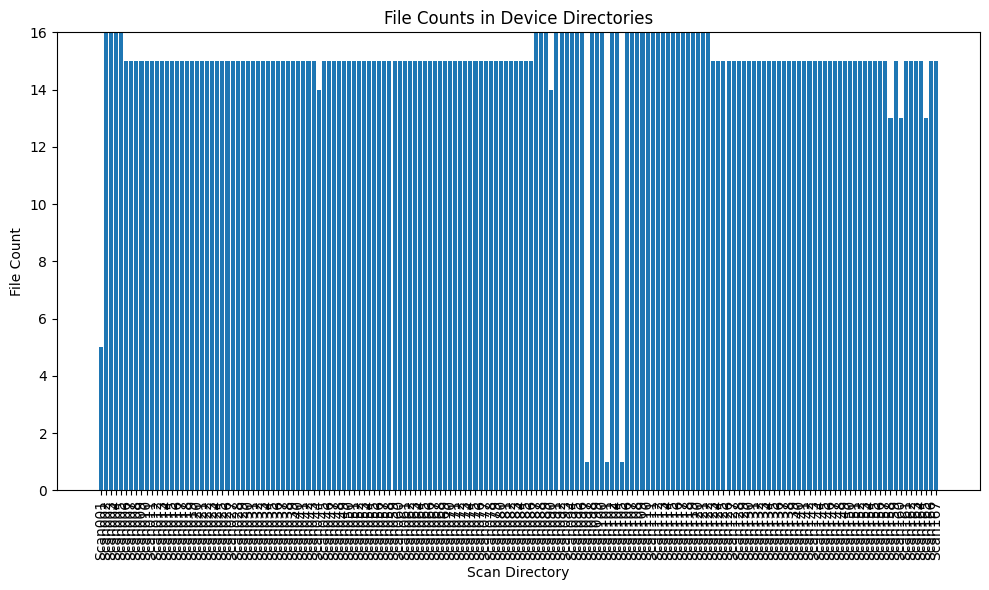

In [22]:
# Base directory where the scanXXX directories are located
base_dir = Path('Z:/data/Undulator/Y2024/03-Mar/24_0328/scans')  # Replace with your actual path

# Dictionary to hold the count of files for each device directory
file_counts = {}

# Iterate through each item in base directory
for scan_dir in base_dir.iterdir():
    if scan_dir.is_dir() and scan_dir.name.startswith('Scan'):
        device_dir = scan_dir / 'UC_UndulatorRad2'
        # Count files in the device directory
        if device_dir.exists():
            count = len(list(device_dir.glob('*png')))  # Assuming you want to count all types of files
            file_counts[scan_dir.name] = count

# Now, plot the file counts
plt.figure(figsize=(10, 6))
plt.bar(range(len(file_counts)), list(file_counts.values()), align='center')
plt.xticks(range(len(file_counts)), list(file_counts.keys()), rotation='vertical')
plt.xlabel('Scan Directory')
plt.ylabel('File Count')
plt.ylim(0,16)
plt.title('File Counts in Device Directories')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [58]:
start_scan = 6+9*5
ebeam_scan_numbers = list(range(start_scan, start_scan+8))
raw_data_path, analysis_data_path = create_data_path(year, month, day, 100)
undulator_scan_dir = Path(analysis_data_path).parent / 'temp'
# year = '2024'
# mone = 'Mar'
# day = '28'


# estats = create_image_grids("UC_VisaEBeam", ebeam_scan_numbers, undulator_scan_dir,  year,  month, day)


In [171]:
scaling = [14,14,14,14,14,14,14,14]
for j in range(8):
    scan_numbers = []
    year = '2024'
    mone = 'Mar'
    day = '28'
    raw_data_path, analysis_data_path = create_data_path(year, month, day, 100)
    device = f"UC_VisaEBeam{j+1}"
    # device = f"UC_UndulatorRad2"

    undulator_scan_dir = Path(analysis_data_path).parent / f'steering_scan1_test_{device}'
    # Create the directory if it doesn't exist
    undulator_scan_dir.mkdir(parents=True, exist_ok=True)    
    
    for i in range(8):
        start_scan = 6+9*i
        ebeam_scan_numbers = list(range(start_scan, start_scan+9))
        s_num = ebeam_scan_numbers[j]

        # raw_data_path, analysis_data_path = create_data_path(year, month, day, ebeam_scan_numbers[1])
        # analysis_settings = get_analysis_settings(device, None)
    
        # full_process(year,month,day,s_num,device, None, show_image = True, plot_label = None)
        scan_numbers.append(s_num)
        
    create_image_grids(device, scan_numbers,undulator_scan_dir,year,month,day,figsize=(5,20),grid_rows=8,grid_cols=1,static_device=True ,normalize=True, scaling=scaling[j])

6
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan006\UC_VisaEBeam1_average_16bit.png
15
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan015\UC_VisaEBeam1_average_16bit.png
24
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan024\UC_VisaEBeam1_average_16bit.png
33
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan033\UC_VisaEBeam1_average_16bit.png
42
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan042\UC_VisaEBeam1_average_16bit.png
51
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan051\UC_VisaEBeam1_average_16bit.png
60
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan060\UC_VisaEBeam1_average_16bit.png
69
UC_VisaEBeam1
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan069\UC_VisaEBeam1_average_16bit.png
7
UC_VisaEBeam2
Z:\data\Undulator\Y2024\03-Mar\24_0328\analysis\Scan007\UC_VisaEBeam2_average_16bit.png
16
UC_VisaEBeam2
Z:\data\Undulator\Y2024\03-Mar\24_0328\a

In [7]:
# # spot check a single scan, device combo

# scan_number = 40
# year = '2024'
# month = 'Mar'
# day = '21'
# device = "UC_UndulatorRad2"
# station = 'Station3'
# # device = "UC_VisaEBeam2"
# # station = None
# full_process(year, month, day, scan_number, device, station)

In [352]:
# fig_paths = []
# all_coords=[]
# for i in [1,2,3,4,5,6,7,8]:
#     device = "UC_UndulatorRad2"
#     scan_number = 37+i
#     fig_path, coords = full_process(year, month, day, scan_number, device, f"Station{i}")
#     fig_paths.append(fig_path)
#     all_coords.append(coords)

# fig_paths = []
# all_coords=[]
# for i in [1,2,3,4,5,6,7,8]:
#     device = "UC_UndulatorRad2"
#     scan_number = 37+i
#     fig_path, coords = full_process(year, month, day, scan_number, device, f"Station{i}")
#     fig_paths.append(fig_path)
#     all_coords.append(coords)


In [8]:
# grid_rows = 2
# grid_cols = 4
# fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 7))

# for ax, plot_path in zip(axs.flat, fig_paths):
#     img = plt.imread(plot_path)
#     ax.imshow(img)
#     ax.axis('off')  # Optionally hide the axis

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [369]:
# scan_number = 46
# year = '2024'
# month = 'Mar'
# day = '21'
# st = 900
# scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)

# create_avg_image(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{st}', show_image = True)
# create_avg_image(scan_dir_base, analysis_dir_base, f'UC_UndulatorRad2',station = f'Station{st}', show_image = True)


Created or found existing directory: /Volumes/vol1/data/Undulator/Y2024/03-Mar/24_0321/analysis/undulator_screen_scan2
